# Initial Analysis

The plots below were obtained under the following conditions:

* Small, CNN Model
* Cifar-10 dataset
* Batchsize 32
* 4 epochs of training
* 0.5 second sampling intervals

A struct was used to collect some meaningful data during execution. Data collected for each sample interval includes:

* Number of virtual page frames resident in memory (but not necessarily active)
* Number of vitrual page frames marked as active (i.e. working set size)
* The total size of all the Virtual Memory Areas (VMAs) allocated to this process.
* The maximum stack depth of a page frame accessed.

In addition, the `distance` field of the struct is of type `Dict{Int,Int}` where the keys are depth in the stack and values are the number of times that depth was seen.

In [40]:
# stdlib imports
using Serialization

# Add plots library
using Plots
pyplot() # Use PyPlot (aka matplotlib) backend

# Activate the environment in the "Launcher" project folder
using Pkg
Pkg.activate("../Launcher")

# Import the Launcher module, as well as the MemSnoop module
using Launcher; using MemSnoop

# Deserialize the tracker struct that was used to record various metrics from a run.
tracker = open(deserialize, "cifar_tracker.jls");

# Setup some helpful functions

# Size of a page frame in MiB
size_mb(x) = 4 * x / 1024
make_cdf(x::MemSnoop.StackTracker) = MemSnoop.cdf(MemSnoop.transform(x.distances))
memory_vec(x) = size_mb.(1:length(x))

memory_vec (generic function with 1 method)

## Plot of various working sizes

We have three measures of memory use:

* The total address space of VMAs assigned to Tensorflow process (not every virtual address in this space is necessarily materialized into a physical page resident in memory)
* The virtual pages that are resident in memory but not necessarily active
* The virtual pages that are actually marked as active

Below, we plot the total amount of memory in each category on the same plot.

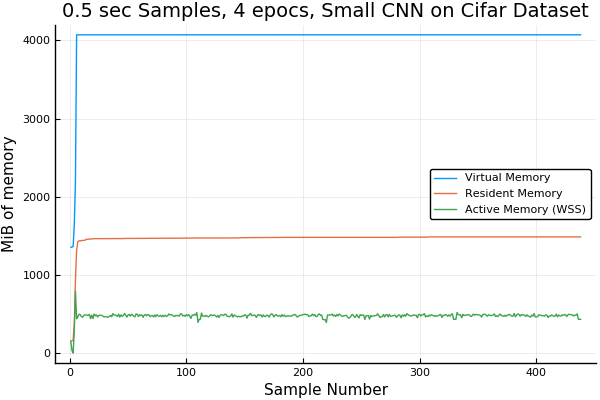

In [46]:
plot(tracker.vma_size ./ (1024 * 1024), lab = "Virtual Memory")
plot!(size_mb(tracker.resident_pages), lab = "Resident Memory")
plot!(size_mb(tracker.active_pages), lab = "Active Memory (WSS)")

# Setup some plot labels
title!("0.5 sec Samples, 4 epocs, Small CNN on Cifar Dataset")
xlabel!("Sample Number")
ylabel!("MiB of memory")

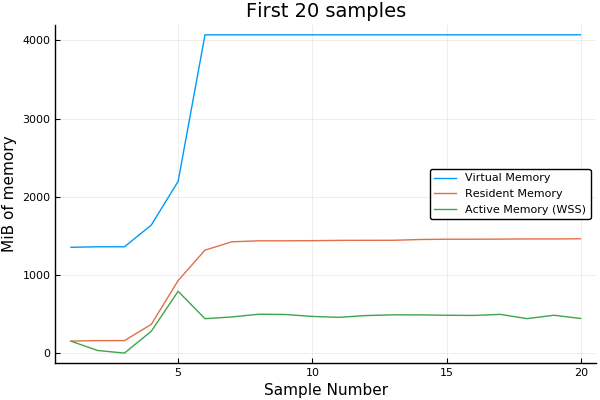

In [49]:
# Take a closer lok at at what happens in the beginning
N = 20 # Take the first N samples

plot((tracker.vma_size ./ (1024 * 1024))[1:N], lab = "Virtual Memory")
plot!(size_mb(tracker.resident_pages)[1:N], lab = "Resident Memory")
plot!(size_mb(tracker.active_pages)[1:N], lab = "Active Memory (WSS)")

# Setup some plot labels
title!("First $N samples")
xlabel!("Sample Number")
ylabel!("MiB of memory")

Some takeaways:

1. The total amount of virtual memory belonging to the application is much greater than the amound of memory that is actually *present* in DRAM (not too surprising)
2. The computer this was running on was not memory starved during this run since the amount of memory resident in DRAM is equal to the peak WSS. In other words, at one point in time (during startup), a bunch of memory was needed. But then only a subset of that memory was accessed. The rest of it was just sitting around in DRAM.
3. The WSS of this application was fairly static once it was training. This is not TOO surprising since the entire dataset can fit in memory, and the CNN itself is pretty small.

## Reuse Distance

A stack-based reuse distance analysis was conducted on the page frame access patterns. (Write up on this TODO). From this analysis, we can generate a CDF plot where the x-axis represents the size of a memory and the y-axis represents the probability that a memory reference will reside within memory (i.e., will not have been evicted ... under some assumptions about LRUish eviction policies)

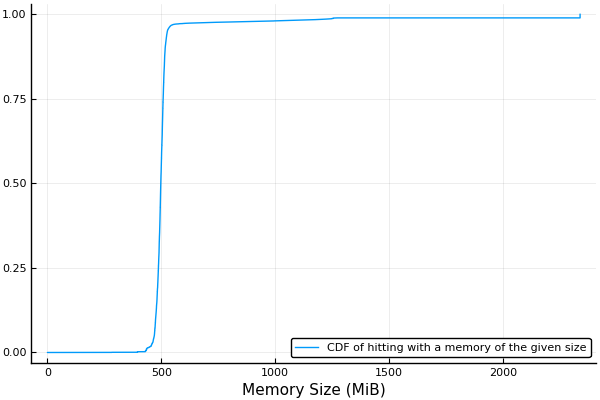

In [42]:
# Use some methods inside MemSnoop.jl to transform the "distance" dictionary into a more useful form for plotting
# The way this is 
cdf = make_cdf(tracker)
memory = memory_vec(cdf)

plot(memory, cdf, lab = "CDF of hitting with a memory of the given size")
xlabel!("Memory Size (MiB)")

### Analysis

I don't think it's too surprising that we see a sharp increase around 500 MB, since this is the average value returned by the WSS analysis. It seems that this particular workload is pretty all or nothing.

## Further Questions

1. WHAT exactly is the WSS made of. Is it model data? Image data? What fraction of each? How do we figure this out?
2. How do these plots change for different batch sizes, and for comparing RESNET.
3. How much is sample time influencing the results we see. Maybe plot WSS as a function of sample time?

# Investigating the effect of Sample Interval

This was run under the the following conditions:

* Small CNN on the Cifar dataset
* Batch size of 128
* Sample intervals of 0.5, 1, 2, 4, and 10 seconds
* 2 epochs of training

Array{MemSnoop.StackTracker,1}

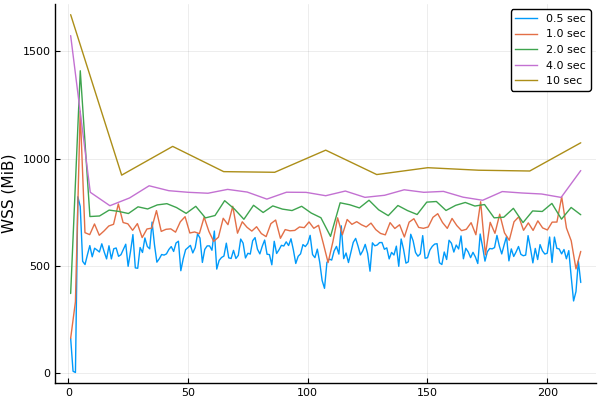

In [21]:
trackers = open(deserialize, "cifar_intervals.jls")
display(typeof(trackers))

# Get the working set sizes of each tracker
wss_sizes = size_mb.([t.active_pages for t in trackers])

# This is just a trick to get everything to be on the same scale
x_values = [range(1, stop = length(first(wss_sizes)), length = length(i)) for i in wss_sizes]

labels = ["0.5 sec", "1.0 sec", "2.0 sec", "4.0 sec", "10 sec"]
plot()
for (x,y,l) in zip(x_values, wss_sizes, labels)
    plot!(x, y, lab = l)
end
ylabel!("WSS (MiB)")

The WSS estimate increases as sample time increases. This is not surprising. What we can take away from this is that the WSS estimate is logarithmic-ish with the sample time. That is, from a 0.5 sec interval to a 10 sec interval, (a 20x increase in sample window time), the WSS estimate grew by a factor of 2.

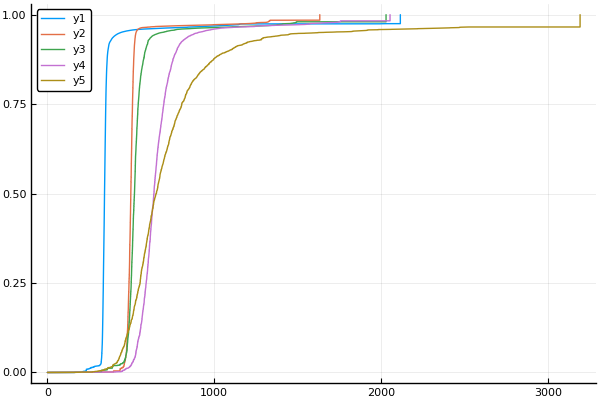

In [53]:
N = 5
cdfs = make_cdf.(trackers)
memories = memory_vec.(cdfs)

plot(memories[1:N], cdfs[1:N])

# Batch Sizes

Batch sizes tried: (16, 32, 64, 128, 256, 512, 1024)

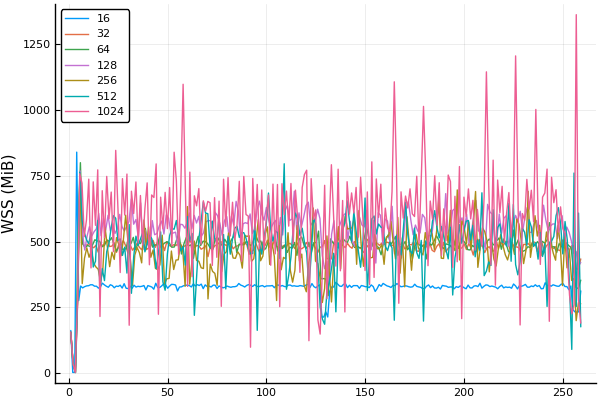

In [30]:
trackers = open(deserialize, "cifar_batches.jls")

# Get the working set sizes of each tracker
wss_sizes = size_mb.([t.active_pages for t in trackers])

# This is just a trick to get everything to be on the same scale
x_values = [range(1, stop = length(first(wss_sizes)), length = length(i)) for i in wss_sizes]

labels = ["16", "32", "64", "128", "256", "512", "1024"]
plot()
for (x,y,l) in zip(x_values, wss_sizes, labels)
    plot!(x, y, lab = l)
end
ylabel!("WSS (MiB)")

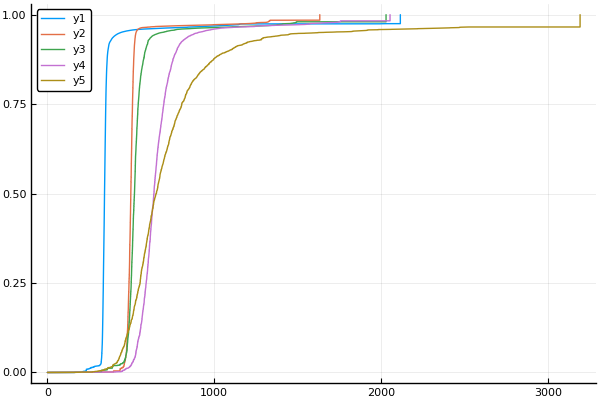

In [43]:
cdfs = make_cdf.(trackers)
memories = memory_vec.(cdfs)

plot(memories[1:end-2], cdfs[1:end-2])

# Resnet

Lets see quickly how Resnet compares.

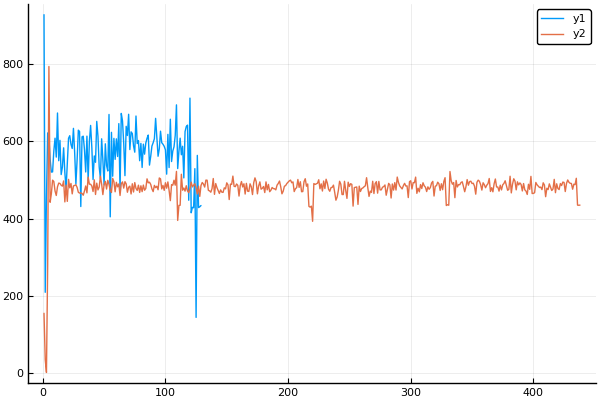

In [35]:
tracker = open(deserialize, "cifar_resnet_1.jls")

plot(size_mb.(tracker.active_pages))

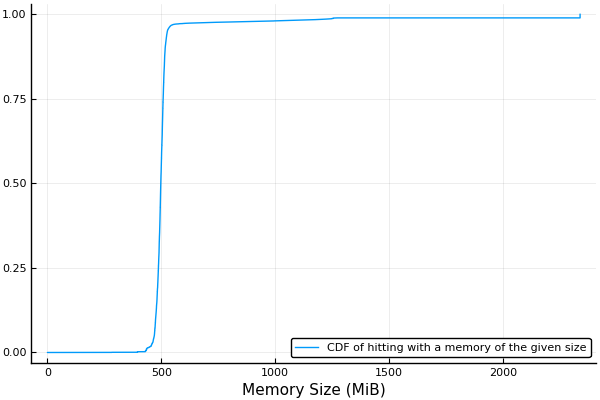

In [44]:
cdf = make_cdf(tracker)
memory = memory_vec(cdf)

plot(memory, cdf, lab = "CDF of hitting with a memory of the given size")
xlabel!("Memory Size (MiB)")

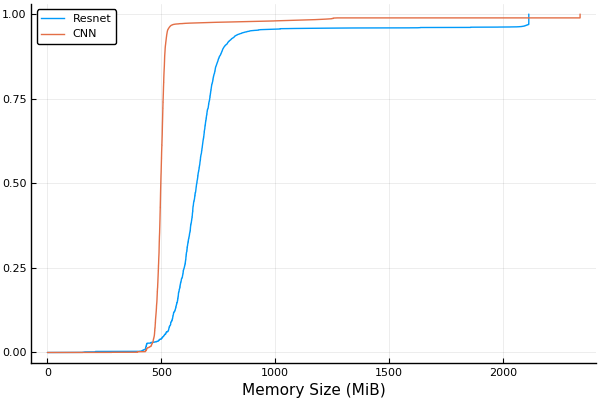

In [45]:
resnet_tracker = open(deserialize, "cifar_resnet_1.jls")
cnn_tracker = open(deserialize, "cifar_tracker.jls")

cdf_resnet = make_cdf(resnet_tracker)
memory_resnet = memory_vec(cdf_resnet)

cdf_cnn = make_cdf(cnn_tracker)
memory_cnn = memory_vec(cdf_cnn)

plot(memory_resnet, cdf_resnet, lab = "Resnet")
plot!(memory_cnn, cdf_cnn, lab = "CNN")
xlabel!("Memory Size (MiB)")